# The study of the interaction of Blue crab Callinectes sapidus and soft-shell clam Mya arenaria on a mathematical model.

### the selected dataset: https://search.dataone.org/view/doi%3A10.5063%2FF19S1PB9

This time series was used in a Lotka-Volterra predator-prey model to predict prey densities and predation rates
in a natural environment.

Agreement between model predictions and field data in this crab-clam predator-prey system indicates that relatively
simple models can be used to predict phase shifts and identify alternative stable states.

##### dataset representation
the dataset presented as csv file with two columns:
* Clam data -- are Chesapeake Bay Mya arenaria landings, in thousands of bushels
* Crab data -- are log-transformed average adult female Callinectes sapidus abundance per tow from the Virginia Institute of Marine Science trawl survey.

each row represents amounts of calm and crab

### THE ROSENZWEIG-MACARTHUR PREDATOR-PREY MODEL

were chosen THE ROSENZWEIG-MACARTHUR PREDATOR-PREY MODEL because selected dataset presented on range 1958 - 1992 (34 years)
and therefore a lot preys will be left by themselves

* dx/dt = (a - a * x - y * h(x)) * x -- prey equation

* dy/dt = (-b + c * h(x) * x) * y -- predator equations

where h(x) is how many victims will the predator kill

* h(x) = x * s / (x * s * t + 1)

### the final system of equations
* x' = (a - a * x) * x - y * (x * s / (x * s * t + 1))
* y' = (-b + c * (x * s / (x * s * t + 1))) * y

In [ ]:
from scipy import integrate, optimize
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### h(x) visual representation

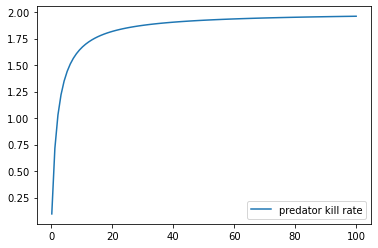

In [21]:
s = 1
tau = 0.5
x_space = np.linspace(0.1, 100, 100)
y_space = np.zeros(x_space.shape)

def h(x):
    return x * s / ( x * s * tau + 1)

for idx, x_v in enumerate(x_space):
    y_space[idx] = h(x_v)

plt.plot(x_space, y_space, label="predator kill rate")
plt.legend()
plt.show()

### dataset visualization
#### we assume that the plots depend on the type of predator prey model

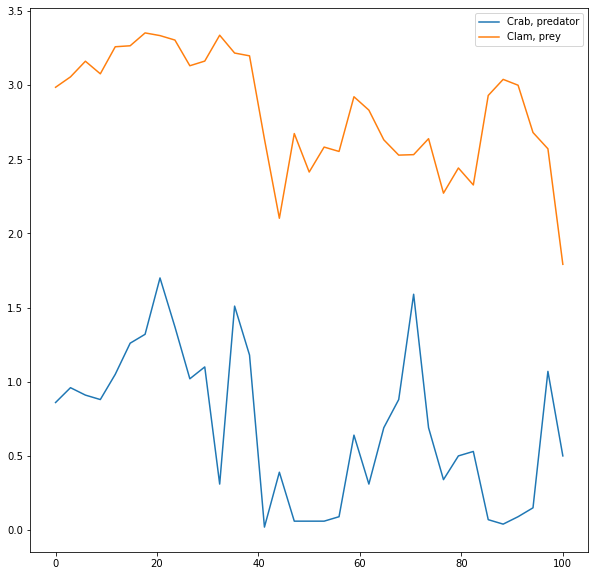

In [38]:
t = np.linspace(0, 100, 35)

frame = pd.read_csv("/Users/nduginets/PycharmProjects/master-diploma/time series.csv")

# Year,Crab,Clam
x = frame["Year"]
plt.figure(figsize=(10, 10))
predator = np.array(frame["Crab"])
prey = np.log(np.array(frame["Clam"])) / 2

plt.plot(t, predator, label="Crab, predator")
plt.plot(t, prey, label="Clam, prey")
plt.legend()
plt.show()

#### let's visualize THE ROSENZWEIG-MACARTHUR PREDATOR-PREY MODEL with random values

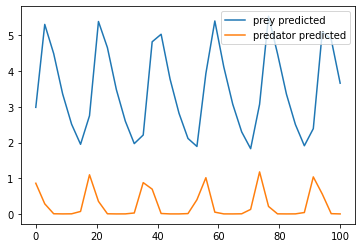

In [98]:
X0 = np.array([predator[0], prey[0]])

def integrate(func, args):
    return pd.DataFrame(integrate.odeint(func, X0, t, args=args))

def h(x, s, tow):
    return x * s / (s * tow * x + 1)

def fun(X, t, b, c, d, s, tow):
    x, y = X
    dxdt = b * x - b * x * x / 2 - h(x, s, tow) * y
    dydt = -d * y + c * y * h(x, s, tow)
    return dxdt, dydt

res = integrate(fun, args=tuple([3, 0.8, 0.1, 0.9, 1.1]))

plt.plot(t, res[1], label="prey predicted")
plt.plot(t, res[0], label="predator predicted")
plt.legend()
plt.show()


In [99]:
def loss_prey(X):
    mse = MSE(integrate(fun, tuple(X))[1], prey)
    return mse

def loss_preadator(X):
    mse = MSE(integrate(fun, tuple(X))[0], predator)
    return mse


def combined_loss(k1 = 1, k2=1):
    def f(X):
        mse1 = MSE(integrate(fun, tuple(X))[1], prey)
        mse2 = MSE(integrate(fun, tuple(X))[0], predator)
        return k1 * mse1 + k2 * mse2
    return f

## try to fit model to the dataset

#### minimize MSE uses the prey only data

[ 0.11501892  2.29325908  0.04243497  0.02805202 -1.30152939]
[ 0.11501892  2.29325908  0.04243497  0.02805202 -1.30152939]


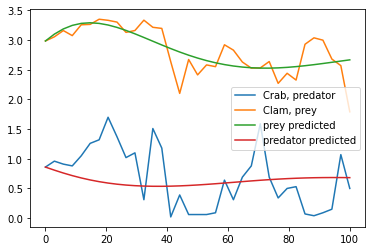

In [111]:
res = optimize.minimize(loss_prey, np.array([0.7, 4.5, 0.2, 0.8, 1]), method='Nelder-Mead').x
print(res)
print(res)

predicted = integrate(fun, args=tuple(res))
# res

plt.plot(t, predator, label="Crab, predator")
plt.plot(t, prey, label="Clam, prey")
plt.plot(t, predicted[1], label="prey predicted")
plt.plot(t, predicted[0], label="predator predicted")
plt.legend()
plt.show()

#### minimize MSE uses the predator only data

[2.90620265 0.25289484 0.1202841  1.41952199 1.09181507]


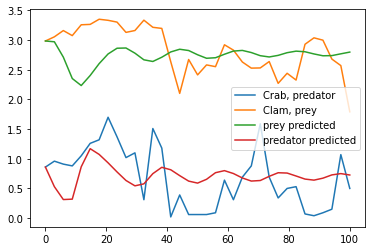

In [108]:
np.array([1, 1.5, 0.2, 0.8, 1, 2])
res = optimize.minimize(loss_preadator, np.array([1, 1.5, 0.2, 0.8, 1]), method='Nelder-Mead').x
print(res)

predicted = integrate(fun, args=tuple(res))
# res

plt.plot(t, predator, label="Crab, predator")
plt.plot(t, prey, label="Clam, prey")
plt.plot(t, predicted[1], label="prey predicted")
plt.plot(t, predicted[0], label="predator predicted")
plt.legend()
plt.show()

#### minimize MSE uses weighted loss with the predator and the prey data

[4.2630196  0.36161306 0.21447403 1.78900217 0.8358024 ]


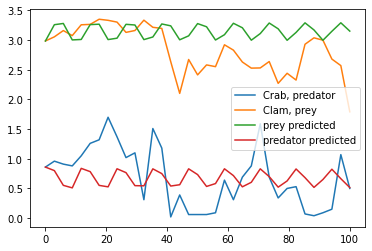

In [104]:
res = optimize.minimize(combined_loss(1, 1), np.array([4, 1.5, 0.2, 0.8, 1]), method='Nelder-Mead').x
print(res)


predicted = integrate(fun, args=tuple(res))
# res

plt.plot(t, predator, label="Crab, predator")
plt.plot(t, prey, label="Clam, prey")
plt.plot(t, predicted[1], label="prey predicted")
plt.plot(t, predicted[0], label="predator predicted")
plt.legend()
plt.show()

## conclusion

In this work was investigated THE ROSENZWEIG-MACARTHUR PREDATOR-PREY MODEL,
for this model were used 5 variable parameters which were fitted by the MSE method.

after comparing models I noticed that fitting model by prey data only leads to huge phase,
at the same time use predator data only or weighted loss with the predator and prey datasets give adequate results.